#### Import library

In [ ]:
# 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd # 데이터 구성 패키지( series, dataframe )
import numpy as np # 행렬 연산 패키지
# 데이터 시각화
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# 나무 구조 생성 및 저장
from sklearn.tree import export_graphviz
# 나무 구조 시각화
import graphviz
# scale 변환 -> 표준화 회귀계수 산출
from sklearn.preprocessing import StandardScaler
# 학습용/평가용 데이터 분리 : train, test
from sklearn.model_selection import train_test_split

# 로지스틱 회귀
from statsmodels.api import Logit
# 분류 Decision Tree
from sklearn.tree import DecisionTreeClassifier as DTC
# 분류 Random Forest
from sklearn.ensemble import RandomForestClassifier as RFC
# 분류 Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier as GBC
# 분류 XGBoost
from xgboost import XGBClassifier as XGBC
# 분류 LightGBM
from lightgbm import LGBMClassifier as LGBNC
# 분류 CatBoost
from catboost import CatBoostClassifier as CBC
# 분류 SVM
from sklearn.svm import SVC
# 분류 NN
from sklearn.neural_network import MLPClassifier as MLPC
# 분류 KNN
from sklearn.neighbors import KNeighborsClassifier as KNC

# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
# 변수 중요도 확인 : f1-score 기준
from xgboost import plot_importance
from lightgbm import plot_importance


In [ ]:
# 한글 폰트
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['font.family'] = 'NanumBarunGothic'
# 음수
plt.rcParams['axes.unicode_minus']=False
# 에러 무시
import warnings
warnings.filterwarnings(action='ignore')
# 모든 컬럼 출력
pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows',400)
sns.set(rc={'figure.figsize':(10, 5)})

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0, Load Data

In [ ]:
# 데이터 불러오기
df_org=pd.read_csv("/content/drive/MyDrive/TIL/포스코 AI Big Data 아카데미/2. Big Data/종합실습/SCALE불량.csv", encoding='euc-kr')
df_raw=df_org.copy()

In [ ]:
df_raw.sample(3)

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
837,PLT_1838,09JAN2023:03:21:01,양품,AB/A,미국,C,14,2600,54100,적용,3호기,2열,1156,78,1168,76,255,1168,CR(제어압연),947,10,4조
434,PLT_1435,06JAN2023:08:02:37,양품,AB/A,미국,C,12,3400,43100,적용,1호기,2열,1184,76,1172,70,247,1172,CR(제어압연),906,10,1조
386,PLT_1387,06JAN2023:00:23:04,양품,LR-B,영국,C,19,3600,41000,적용,3호기,1열,1186,73,1172,53,232,1172,CR(제어압연),993,10,2조


In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   plate_no         1000 non-null   object
 1   rolling_date     1000 non-null   object
 2   scale            1000 non-null   object
 3   spec_long        1000 non-null   object
 4   spec_country     1000 non-null   object
 5   steel_kind       1000 non-null   object
 6   pt_thick         1000 non-null   int64 
 7   pt_width         1000 non-null   int64 
 8   pt_length        1000 non-null   int64 
 9   hsb              1000 non-null   object
 10  fur_no           1000 non-null   object
 11  fur_input_row    1000 non-null   object
 12  fur_heat_temp    1000 non-null   int64 
 13  fur_heat_time    1000 non-null   int64 
 14  fur_soak_temp    1000 non-null   int64 
 15  fur_soak_time    1000 non-null   int64 
 16  fur_total_time   1000 non-null   int64 
 17  fur_ex_temp      1000 non-null   i

In [ ]:
df_raw.describe()

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_temp,descaling_count
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,26.78200,2831.900000,36788.200000,1157.245000,85.972000,1150.928000,71.720000,238.589000,1150.928000,934.637000,8.557000
std,18.13757,494.081478,13912.387116,21.245007,26.346297,17.344384,20.602137,38.194828,17.344384,96.598015,1.604158
min,12.00000,1800.000000,7900.000000,1103.000000,55.000000,1113.000000,35.000000,165.000000,1113.000000,0.000000,5.000000
25%,15.00000,2500.000000,26650.000000,1140.000000,66.000000,1135.750000,57.750000,210.000000,1135.750000,893.750000,8.000000
50%,19.00000,2800.000000,40400.000000,1159.000000,75.000000,1156.000000,66.000000,230.000000,1156.000000,948.000000,9.000000
75%,34.00000,3100.000000,49100.000000,1173.000000,102.250000,1164.000000,81.000000,263.000000,1164.000000,991.000000,10.000000
max,100.00000,4600.000000,54900.000000,1206.000000,158.000000,1185.000000,145.000000,362.000000,1185.000000,1078.000000,10.000000


In [ ]:
df_num_cols=df_raw[['pt_thick','pt_width','pt_length','fur_heat_temp','fur_heat_time','fur_soak_temp','fur_soak_time','fur_total_time','rolling_temp','descaling_count']]
df_num_cols.sample(1)

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count
489,19,3100,42200,1195,72,1165,49,215,989,10


## 1, Data Cleansing

In [ ]:
df_raw.scale.unique()

array(['양품', '불량'], dtype=object)

In [ ]:
change={'불량': 1, '양품':0}
df_raw['scale']=df_raw['scale'].map(change)
df_raw.sample(3)

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
238,PLT_1239,04JAN2023:22:36:04,1,CCS-B,프랑스,C,30,2200,38900,적용,2호기,1열,1155,74,1153,92,249,1153,CR(제어압연),1004,8,2조
954,PLT_1955,09JAN2023:22:50:43,0,GL-A32,독일,C,12,2800,54400,적용,1호기,2열,1172,60,1161,74,216,1161,CR(제어압연),919,10,4조
657,PLT_1658,07JAN2023:21:10:41,0,AB/A,미국,C,13,3400,43400,적용,1호기,2열,1165,115,1139,47,224,1139,CR(제어압연),904,10,4조


양품을 0, 불량을 1으로 구분하였다.

In [ ]:
df_raw=df_raw.drop('plate_no', axis=1)
df_raw=df_raw.drop('rolling_date', axis=1)

plate 번호( plate_no )와 열연작업시각( rolling_date )은 scale 불량을 예측하는 것과 무관하므로 해당 컬럼을 제거하였다.

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scale            1000 non-null   int64 
 1   spec_long        1000 non-null   object
 2   spec_country     1000 non-null   object
 3   steel_kind       1000 non-null   object
 4   pt_thick         1000 non-null   int64 
 5   pt_width         1000 non-null   int64 
 6   pt_length        1000 non-null   int64 
 7   hsb              1000 non-null   object
 8   fur_no           1000 non-null   object
 9   fur_input_row    1000 non-null   object
 10  fur_heat_temp    1000 non-null   int64 
 11  fur_heat_time    1000 non-null   int64 
 12  fur_soak_temp    1000 non-null   int64 
 13  fur_soak_time    1000 non-null   int64 
 14  fur_total_time   1000 non-null   int64 
 15  fur_ex_temp      1000 non-null   int64 
 16  rolling_method   1000 non-null   object
 17  rolling_temp     1000 non-null   i

In [ ]:
df_raw.isnull().sum()

scale              0
spec_long          0
spec_country       0
steel_kind         0
pt_thick           0
pt_width           0
pt_length          0
hsb                0
fur_no             0
fur_input_row      0
fur_heat_temp      0
fur_heat_time      0
fur_soak_temp      0
fur_soak_time      0
fur_total_time     0
fur_ex_temp        0
rolling_method     0
rolling_temp       0
descaling_count    0
work_group         0
dtype: int64

결측치는 보이지 않았다.

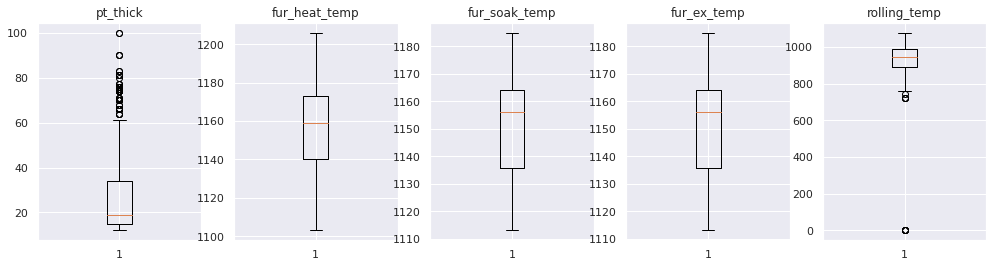

In [ ]:
# 이상치 확인
fig, ax=plt.subplots(1,5,figsize=(17,4))
ax[0].boxplot(df_raw.pt_thick)
ax[0].set_title('pt_thick')

ax[1].boxplot(df_raw.fur_heat_temp)
ax[1].set_title('fur_heat_temp')

ax[2].boxplot(df_raw.fur_soak_temp)
ax[2].set_title('fur_soak_temp')

ax[3].boxplot(df_raw.fur_ex_temp)
ax[3].set_title('fur_ex_temp')

ax[4].boxplot(df_raw.rolling_temp)
ax[4].set_title('rolling_temp');

rolling_temp( 압연온도 )에서 압연 온도가 0도일 수 없으므로 이상치로 판단하고, rolling_temp의 평균값으로 대체하였다.

In [ ]:
df_raw=df_raw.replace({'rolling_temp':{0:df_raw.rolling_temp.mean()}})

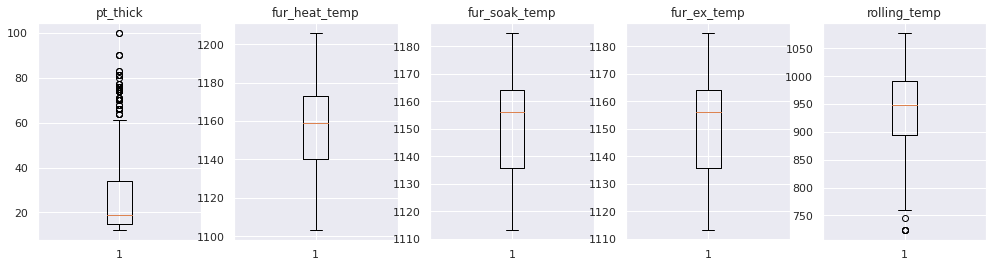

In [ ]:
fig, ax=plt.subplots(1,5,figsize=(17,4))
ax[0].boxplot(df_raw.pt_thick)
ax[0].set_title('pt_thick')

ax[1].boxplot(df_raw.fur_heat_temp)
ax[1].set_title('fur_heat_temp')

ax[2].boxplot(df_raw.fur_soak_temp)
ax[2].set_title('fur_soak_temp')

ax[3].boxplot(df_raw.fur_ex_temp)
ax[3].set_title('fur_ex_temp')

ax[4].boxplot(df_raw.rolling_temp)
ax[4].set_title('rolling_temp');

In [ ]:
# 기술 통계량
df_raw.describe()

,scale,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_temp,descaling_count
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.310000,26.78200,2831.900000,36788.200000,1157.245000,85.972000,1150.928000,71.720000,238.589000,1150.928000,940.244822,8.557000
std,0.462725,18.13757,494.081478,13912.387116,21.245007,26.346297,17.344384,20.602137,38.194828,17.344384,63.664533,1.604158
min,0.000000,12.00000,1800.000000,7900.000000,1103.000000,55.000000,1113.000000,35.000000,165.000000,1113.000000,723.000000,5.000000
25%,0.000000,15.00000,2500.000000,26650.000000,1140.000000,66.000000,1135.750000,57.750000,210.000000,1135.750000,894.000000,8.000000
50%,0.000000,19.00000,2800.000000,40400.000000,1159.000000,75.000000,1156.000000,66.000000,230.000000,1156.000000,948.000000,9.000000
75%,1.000000,34.00000,3100.000000,49100.000000,1173.000000,102.250000,1164.000000,81.000000,263.000000,1164.000000,991.000000,10.000000
max,1.000000,100.00000,4600.000000,54900.000000,1206.000000,158.000000,1185.000000,145.000000,362.000000,1185.000000,1078.000000,10.000000


## 2, EDA

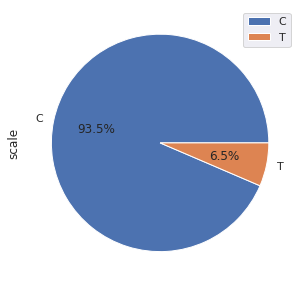

In [ ]:
# Pie Chart로 강종과 불량 비교
defect = df_raw[df_raw["scale"] == 1]
defect_cnt = defect.groupby("steel_kind", as_index = False).agg("count")
defect_cnt.plot.pie(y = "scale", labels = defect_cnt["steel_kind"], autopct= "%.1f%%");

scale 불량 중 93.5%가 탄소강(C)이고, 6.5%가 티타늄강(T)이다.

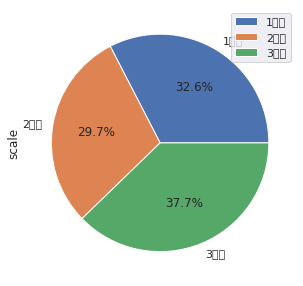

In [ ]:
# Pie Chart로 가열로 호기에 따른 불량 비교
defect = df_raw[df_raw["scale"] == 1]
defect_cnt = defect.groupby("fur_no", as_index = False).agg("count")
defect_cnt.plot.pie(y = "scale", labels = defect_cnt["fur_no"], autopct= "%.1f%%");

scale 불량품 중 37.7%가 3호기에서, 32.6%가 1호기에서, 29.7%가 2호기에서 발생하였다. 가열로 호기에 따른 불량 비교는 유의미하지 않다.

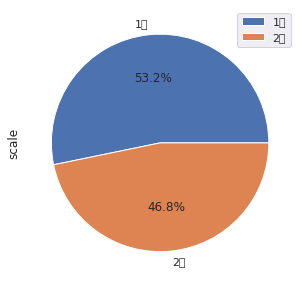

In [ ]:
# Pie Chart로 가열로 장입열에 따른 불량 비교
defect = df_raw[df_raw["scale"] == 1]
defect_cnt = defect.groupby("fur_input_row", as_index = False).agg("count")
defect_cnt.plot.pie(y = "scale", labels = defect_cnt["fur_input_row"], autopct= "%.1f%%");

scale 불량 중 53.2%가 1열에서 발생하였고, 46.8%는 2열에서 발생하였다. 그러나 가열로 장입열 또한 scale 불량에 큰 영향을 미치지 않는 것으로 보인다.

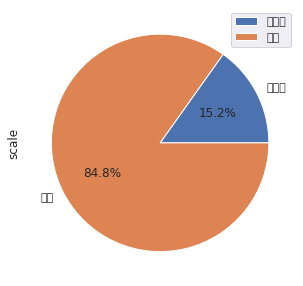

In [ ]:
# Pie Chart로 hot scaler braker 적용 여부와 불량 비교
defect = df_raw[df_raw["scale"] == 1]
defect_cnt = defect.groupby("hsb", as_index = False).agg("count")
defect_cnt.plot.pie(y = "scale", labels = defect_cnt["hsb"], autopct= "%.1f%%");

불량 중 84.9%가 Hot Scale Braker 적용하였고, 15.2%는 적용하지 않았다.

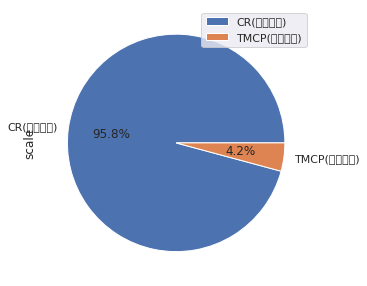

In [ ]:
# Pie Chart로 rolling_method에 따른 scale 불량 비교
defect = df_raw[df_raw["scale"] == 1]
defect_cnt = defect.groupby("rolling_method", as_index = False).agg("count")
defect_cnt.plot.pie(y = "scale", labels = defect_cnt["rolling_method"], autopct= "%.1f%%");

scale 불량 중 95.8%가 TMCP(온도제어/0)에서 발생하였고, CR(제어압연/1)에서는 4.2%가 발생하였다.

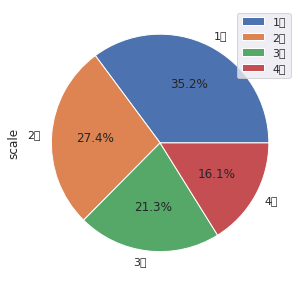

In [ ]:
# Pie Chart로 work_group 따른 scale 불량 비교
defect = df_raw[df_raw["scale"] == 1]
defect_cnt = defect.groupby("work_group", as_index = False).agg("count")
defect_cnt.plot.pie(y = "scale", labels = defect_cnt["work_group"], autopct= "%.1f%%");

ValueError: ignored

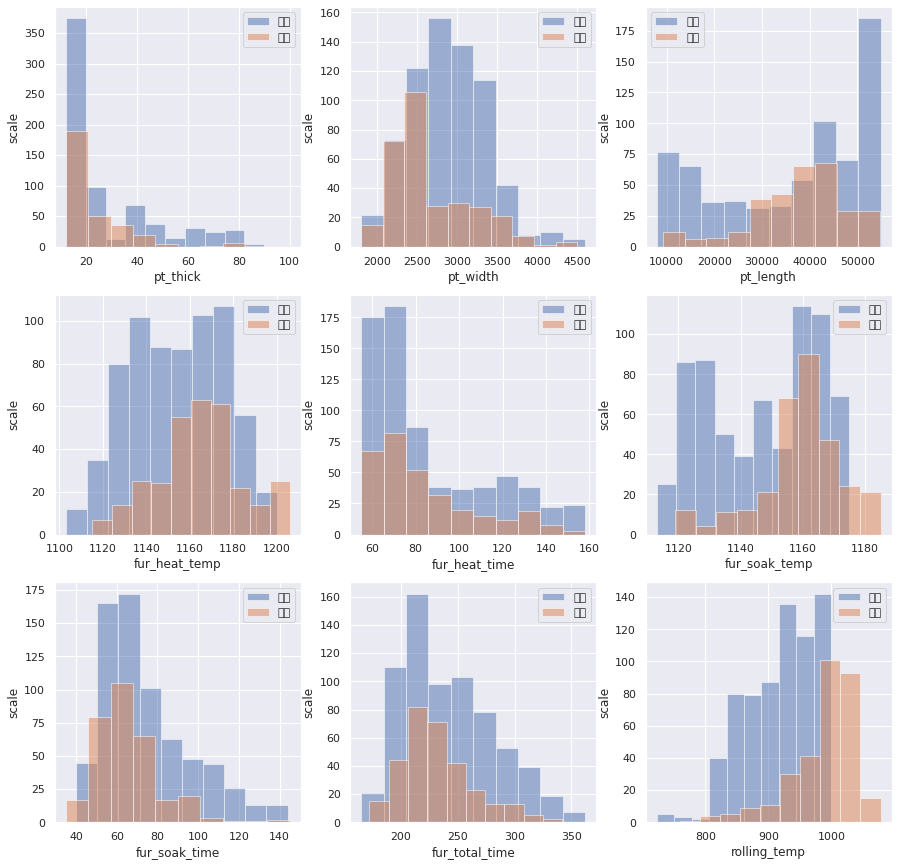

In [ ]:
# 연속형 변수 히스토그램
i = 0
fig = plt.figure(figsize = (15, 15))
columns = df_num_cols.columns
for col in columns:
    plt.subplot(df_num_cols.shape[1]//3, 3, i+1)
    i += 1
    plt.hist(df_raw[df_raw["scale"] == 0][col], label = "양품", alpha = 0.5)
    plt.hist(df_raw[df_raw["scale"] == 1][col], label = "불량", alpha = 0.5)
    plt.xlabel(col)
    plt.ylabel("scale")
    plt.legend()
plt.show()

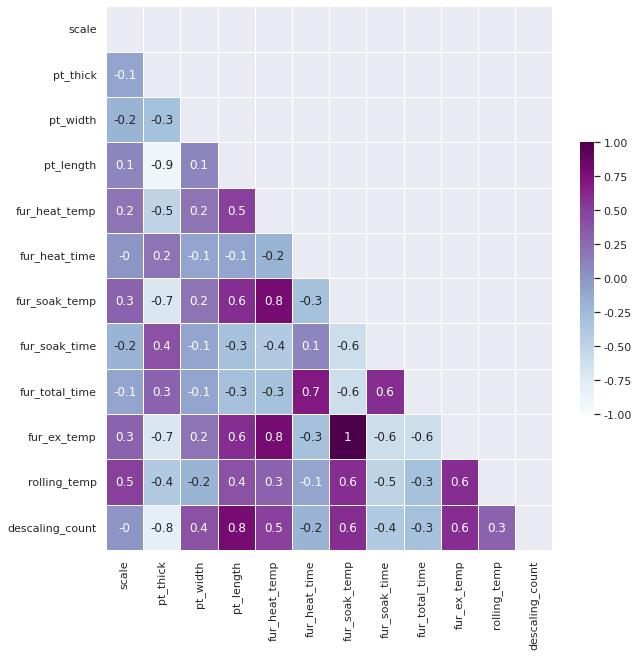

In [ ]:
# 히트맵
df_corr = df_raw.corr().round(1)

fig, ax = plt.subplots(figsize=(10,10))

mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(df_corr,
            cmap='BuPu',
            annot = True,
            mask=mask,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            vmin = -1,vmax = 1
           )
plt.show()

위의 히트맵을 보면 fur_ex_temp와 fur_soak_temp 간에는 강한 양의 상관관계가 있음을 알 수 있다. fur_ex_temp의 scale 불량과의 상관성은 fur_soak_temp와 scale 불량 간의 관계를 통해 유추할 수 있으므로 삭제하였다.

In [ ]:
df_raw=df_raw.drop('fur_ex_temp', axis=1)
df_raw.sample(3)

KeyError: ignored

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   scale            1000 non-null   int64  
 1   spec_long        1000 non-null   object 
 2   spec_country     1000 non-null   object 
 3   steel_kind       1000 non-null   object 
 4   pt_thick         1000 non-null   int64  
 5   pt_width         1000 non-null   int64  
 6   pt_length        1000 non-null   int64  
 7   hsb              1000 non-null   object 
 8   fur_no           1000 non-null   object 
 9   fur_input_row    1000 non-null   object 
 10  fur_heat_temp    1000 non-null   int64  
 11  fur_heat_time    1000 non-null   int64  
 12  fur_soak_temp    1000 non-null   int64  
 13  fur_soak_time    1000 non-null   int64  
 14  fur_total_time   1000 non-null   int64  
 15  rolling_method   1000 non-null   object 
 16  rolling_temp     1000 non-null   float64
 17  descaling_count

## 3, 모델링

In [ ]:
# train / test 데이터 분할
df_train, df_test=train_test_split(df_raw, test_size=0.3, random_state=1234, shuffle=True)
print(f"train data size : {df_train.shape}")
print(f"test data size : {df_test.shape}")

train data size : (700, 19)
test data size : (300, 19)


In [ ]:
# train data
y_train=df_train.scale # 목표변수
x_train=df_train.drop('scale',axis=1) # 설명변수

# test data
y_test=df_test.scale # 목표변수
x_test=df_test.drop('scale',axis=1) # 설명변수

# 변수명 저장
v_feature_name=x_train.columns

### 3-1, 로지스틱 회귀분석

\- 모델 및 회귀계수 검토

In [ ]:
# 변수 역할 지정
log_model=Logit.from_formula("""scale ~ C(spec_country) + C(steel_kind) + pt_thick + pt_width + pt_length + C(hsb)\
                              + C(fur_no) + C(fur_input_row) + fur_heat_temp + fur_heat_time + fur_soak_time + fur_total_time\
                              + rolling_method + rolling_temp + descaling_count + C(work_group)""", df_train)
# 적합
log_res=log_model.fit(method='bfgs')
# 결과 출력
print(log_res.summary())

         Current function value: 0.332910
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  700
Model:                          Logit   Df Residuals:                      675
Method:                           MLE   Df Model:                           24
Date:                Tue, 07 Mar 2023   Pseudo R-squ.:                  0.4613
Time:                        23:30:12   Log-Likelihood:                -233.04
converged:                      False   LL-Null:                       -432.57
Covariance Type:            nonrobust   LLR p-value:                 1.171e-69
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.6000 

로지스텍 회귀모델의 설명력은 46.13%이다. 유의수준 0.05에서 유의한 변수는 spec_country( 제품 규격 기준국 ), work_group( 작업조 ), fur_soak_time이다.

In [ ]:
# train 예측 결과
train_y_pred = log_res.predict(df_train)
train_y_pred_class = (train_y_pred > 0.5).astype(int) # 1과 0을 나누는 임계값
print(f"Train 예측 결과 :\n{train_y_pred_class.sample(5)}")
print(f"Confusion Matrix :\n{confusion_matrix(df_train.scale, train_y_pred_class)}")

Train 예측 결과 :
27     0
293    0
417    0
949    0
791    0
dtype: int64
Confusion Matrix :
[[441  43]
 [ 62 154]]


In [ ]:
# test 예측 결과
test_y_pred = log_res.predict(df_test)
test_y_pred_class = (test_y_pred > 0.5).astype(int) # 1과 0을 나누는 임계값
print(f"Train 예측 결과 :\n{test_y_pred_class.sample(5)}")
print(f"Confusion Matrix :\n{confusion_matrix(df_test.scale, test_y_pred_class)}")

Train 예측 결과 :
566    0
271    1
705    0
241    1
887    0
dtype: int64
Confusion Matrix :
[[187  19]
 [ 24  70]]


In [ ]:
# 평가

# 실제 train  데이터와 예측 결과 비교
print('Train 예측/분류 결과')
print(f"Accuarcy : {accuracy_score(df_train.scale,train_y_pred_class):.3f}")
print(f"Confusion Matrix :\n{confusion_matrix(df_train.scale,train_y_pred_class)}")
print(classification_report(df_train.scale,train_y_pred_class, target_names=['양품','불량'], digits=3))

# 실제 test 데이터와 예측 결과 비교
print('Test 예측/분류 결과')
print(f"Accuarcy : {accuracy_score(df_test.scale,test_y_pred_class):.3f}")
print(f"Confusion Matrix :\n{confusion_matrix(df_test.scale,test_y_pred_class)}")
print(classification_report(df_test.scale,test_y_pred_class, target_names=['양품','불량'],digits=3))

Train 예측/분류 결과
Accuarcy : 0.850
Confusion Matrix :
[[441  43]
 [ 62 154]]
              precision    recall  f1-score   support

          양품      0.877     0.911     0.894       484
          불량      0.782     0.713     0.746       216

    accuracy                          0.850       700
   macro avg      0.829     0.812     0.820       700
weighted avg      0.847     0.850     0.848       700

Test 예측/분류 결과
Accuarcy : 0.857
Confusion Matrix :
[[187  19]
 [ 24  70]]
              precision    recall  f1-score   support

          양품      0.886     0.908     0.897       206
          불량      0.787     0.745     0.765        94

    accuracy                          0.857       300
   macro avg      0.836     0.826     0.831       300
weighted avg      0.855     0.857     0.856       300



로지스틱 회귀 모델의 정분류율은 85.7%이다. 187건을 실제 양품을 양품으로 분류했고, 41건은 실제 양품을 불량으로 분류했으며, 24건은 실제 불량을 양품으로 분류하였고, 70건은 실제 불량을 불량으로 분류하였다. 양품 기준 f1-score는 89.7%이고, 불량 기준 f1-socre는 76.5%이다.

\- 표준화 회귀 계수

In [ ]:
# 변수 타입에 따라 데이터 추출
df_char=df_raw.select_dtypes(include='object')
df_num=df_raw.select_dtypes(exclude='object')

#svm_scaled.fit(df_) data scailing
scaler=StandardScaler()
scaled_num=scaler.fit_transform(df_num)
df_scaled_num=pd.DataFrame(scaled_num, columns=df_num.columns)

# 문자 + 숫자 데이터
df_scaled=pd.concat([df_scaled_num, df_char], axis=1)

df_scaled.scale=np.where(df_scaled.scale>0, 1, 0)

df_scaled_train, df_scaled_test = train_test_split(df_scaled, test_size=0.3, random_state=1234)

df_scaled_model=Logit.from_formula("""scale ~ C(steel_kind) + pt_thick + pt_width + pt_length + C(hsb)\
                              + C(fur_no) + C(fur_input_row) + fur_heat_temp + fur_heat_time + fur_soak_time + fur_total_time\
                              + rolling_method + rolling_temp + descaling_count + C(work_group)""", df_train)

scaled_log_res=df_scaled_model.fit(method = 'bfgs')
print(scaled_log_res.summary())


         Current function value: 0.335218
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  700
Model:                          Logit   Df Residuals:                      681
Method:                           MLE   Df Model:                           18
Date:                Tue, 07 Mar 2023   Pseudo R-squ.:                  0.4575
Time:                        23:30:12   Log-Likelihood:                -234.65
converged:                      False   LL-Null:                       -432.57
Covariance Type:            nonrobust   LLR p-value:                 6.778e-73
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.6128 

In [ ]:
# 변수 scaling 후 모델 평가

# train 예측 결과
train_y_pred = scaled_log_res.predict(df_scaled_train)
train_y_pred_class = (train_y_pred > 0.5).astype(int)
log_train_acc = metrics.accuracy_score(df_scaled_train["scale"], train_y_pred_class)

y_pred = scaled_log_res.predict(df_scaled_test)
y_pred_class = (y_pred > 0.5).astype(int)
y_pred_class.head()
print(log_train_acc)

log_f1_score = f1_score(df_scaled_test["scale"], y_pred_class)
print(log_f1_score)

log_test_acc = metrics.accuracy_score(df_scaled_test["scale"], y_pred_class)
print("Accuracy : {0:.3f}".format(metrics.accuracy_score(df_scaled_test["scale"], y_pred_class)))

0.6914285714285714
0.0
Accuracy : 0.687


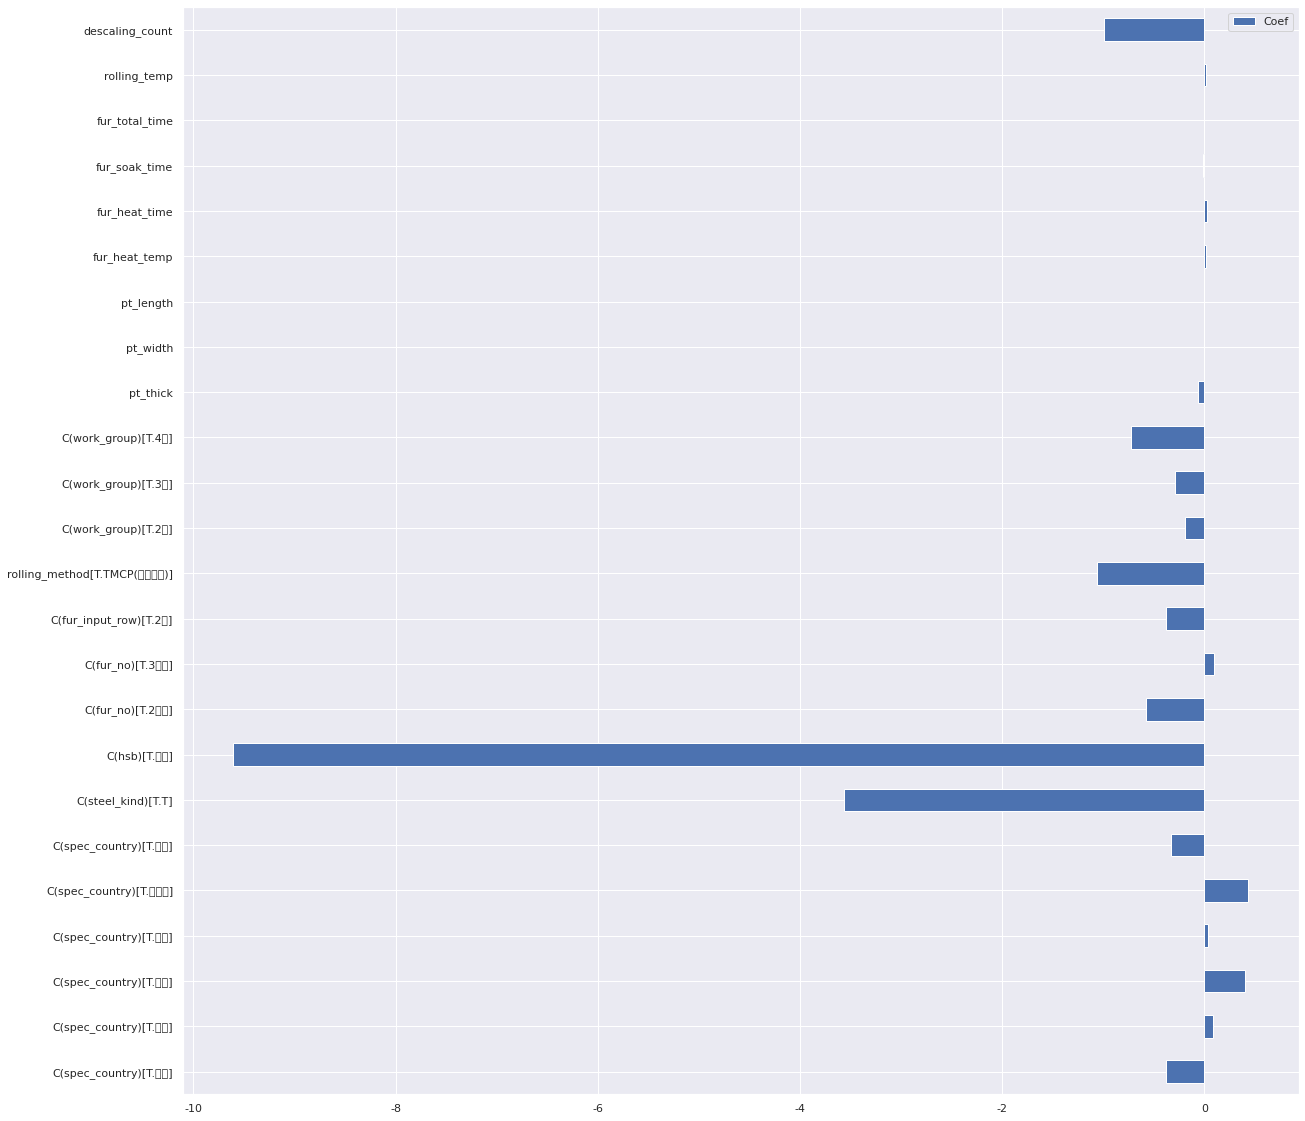

In [ ]:
df_logistic_coef = pd.DataFrame({"Coef": log_res.params.values[1:]}, index = log_model.exog_names[1:])
df_logistic_coef.plot.barh(y = "Coef", figsize=(20,20));

### 3-2, 의사결정나무

In [ ]:
# 더미변수 생성
df_dummy=pd.get_dummies(df_raw)
df_dummy.sample(3)

,scale,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,spec_long_A131-DH36TM,spec_long_A283-C,spec_long_A516-60,spec_long_A709-36,spec_long_AB/A,spec_long_AB/AH32,spec_long_AB/B,spec_long_AB/EH32-TM,spec_long_AB/EH36-TM,spec_long_API-2W-50T,spec_long_BV-A,spec_long_BV-AH32,spec_long_BV-AH32-TM,spec_long_BV-AH36-TL,spec_long_BV-AH36-TM,spec_long_BV-B,spec_long_BV-EH32-TM,spec_long_BV-EH36-TM,spec_long_CCS-B,spec_long_COMMON,spec_long_GL-A,spec_long_GL-A32,spec_long_GL-A32-TM,spec_long_GL-A36-TM,spec_long_GL-D36-TM,spec_long_GL-E32-TM,spec_long_GL-E36-TM,spec_long_JS-SM400A,spec_long_JS-SM400B,spec_long_JS-SM490A,spec_long_JS-SM490YA,spec_long_JS-SM490YB,spec_long_JS-SS400,spec_long_KR-A,spec_long_KR-AH32,spec_long_KR-B,spec_long_KS-HSB500,spec_long_KS-HSB600,spec_long_KS-SM400A,spec_long_KS-SM400B,spec_long_KS-SM490A,spec_long_KS-SM490B,spec_long_KS-SS400,spec_long_LR-A,spec_long_LR-AH32,spec_long_LR-AH36,spec_long_LR-AH36-TM,spec_long_LR-B,spec_long_LR-EH32-TM,spec_long_LR-EH36-TM,spec_long_NK-KA,spec_long_NK-KA32,spec_long_NK-KA32-TM,spec_long_NK-KD36-TM,spec_long_NV-A,spec_long_NV-A32,spec_long_NV-A32-TM,spec_long_NV-A36-TM,spec_long_NV-B,spec_long_NV-D32-TM,spec_long_NV-D36-TM,spec_long_NV-E32-TM,spec_long_NV-E36-TM,spec_long_PILAC-BT33,spec_long_SA283-C,spec_long_V42JBN3,spec_country_공통,spec_country_독일,spec_country_미국,spec_country_영국,spec_country_일본,spec_country_프랑스,spec_country_한국,steel_kind_C,steel_kind_T,hsb_미적용,hsb_적용,fur_no_1호기,fur_no_2호기,fur_no_3호기,fur_input_row_1열,fur_input_row_2열,rolling_method_CR(제어압연),rolling_method_TMCP(온도제어),work_group_1조,work_group_2조,work_group_3조,work_group_4조
335,0,25,3000,31000,1140,66,1155,55,188,899.0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,1,0,1,0,0,0
446,1,15,3300,39900,1199,73,1183,55,214,952.0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0
783,0,13,2800,54900,1167,66,1158,84,248,933.0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0


In [ ]:
# 데이터 분할
df_y=df_dummy['scale']
df_x=df_dummy.drop('scale',axis=1, inplace=False)
df_train_x, df_test_x, df_train_y, df_test_y=train_test_split(df_x, df_y, shuffle=True, test_size=0.3, random_state=1234)
print(f"Train data X size : {df_train_x.shape}")
print(f"Train data Y size : {df_train_y.shape}")
print(f"Test data X size : {df_test_x.shape}")
print(f"Test data Y size : {df_test_y.shape}")

Train data X size : (700, 98)
Train data Y size : (700,)
Test data X size : (300, 98)
Test data Y size : (300,)


In [ ]:
# 의사결정나무 모델 생성 - GridSearchCV를 이용하여 최적의 파라미터 찾기
# p_grid={'criterion':['gini', 'entropy'],
#         'max_depth':[i for i in range(1,11)],
#         'min_samples_split':[i*10 for i in range(1,11)],
#         'min_samples_leaf' : [i*2 for i in range(1,11)]}
train_accuracy=[]
test_accuracy=[]
p_criterion=[]
p_depth=[]

# tree=GridSearchCV(DTC(random_state=1234), p_grid)
tree=DTC(criterion="entropy",max_depth=13,min_samples_split=22, min_samples_leaf=11)
tree.fit(df_train_x, df_train_y)
train_accuracy.append(tree.score(df_train_x, df_train_y))
test_accuracy.append(tree.score(df_test_x, df_test_y))
# print(tree.best_params_)

tree_train_accuracy=tree.score(df_train_x, df_train_y)
tree_test_accuracy=tree.score(df_test_x, df_test_y)
tree_f1_score=f1_score(df_test_y, tree.predict(df_test_x))

df_gridsearch=pd.DataFrame()
df_gridsearch['TrainAccuracy']=train_accuracy
df_gridsearch['TestAccuracy']=test_accuracy
df_gridsearch

,TrainAccuracy,TestAccuracy
0,0.987143,0.99


최대 깊이는 8, 잎사귀의 최소 샘플 수는 22, 분리 노드의 최소 샘플 수는 10이고, 정확도는 99%이다. GridSearchCV는 fit을 이용하여 data를 적합시킬 때 train/validation 데이터로 나누어 cross-validation을 적용한다.

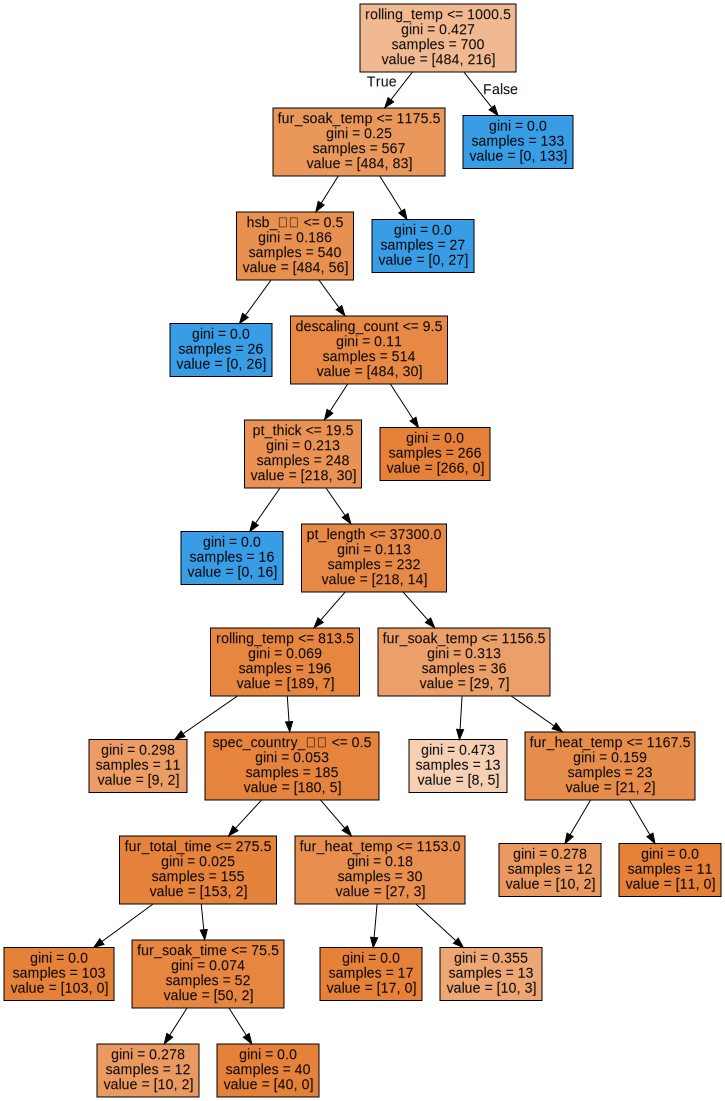

In [ ]:
# 의사결정나무 최종 모델 시각화
tree_fin=DTC(random_state=1234, min_samples_leaf=11, min_samples_split=22, max_depth=13).fit(df_train_x, df_train_y)
# 모델 시각화
tree_v=export_graphviz(tree_fin, out_file=None, feature_names=df_train_x.columns, impurity=True, filled=True)
dtr=graphviz.Source(tree_v)
dtr

In [ ]:
# 설명변수의 중요도
df_feature_importance = pd.DataFrame()
df_feature_importance["Feature"] = df_train_x.columns
df_feature_importance["Importance"] = tree_fin.feature_importances_
df_feature_importance.sort_values("Importance", ascending = False, inplace = True)
df_feature_importance.round(3)

,Feature,Importance
8,rolling_temp,0.567
86,hsb_적용,0.158
5,fur_soak_temp,0.154
0,pt_thick,0.095
9,descaling_count,0.014
2,pt_length,0.006
3,fur_heat_temp,0.004
6,fur_soak_time,0.002
79,spec_country_영국,0.001
7,fur_total_time,0.000


설명변수의 중요도를 확인한 결과, rolling_temp(압연온도), hsb(HSB 적용 여부), fur_soak_temp(가열로 균열대 재로시간), descaling_count(압연Descaling횟수)의 순으로 유의미한 변수를 선택하였다.

### 3-3, 앙상블 - 랜덤 포레스트

In [ ]:
# GridSearchCV를 이용하여 최적 parameter 찾아 랜덤 포레스트 모델 생성하였다.

# p_grid={'n_estimators':[i*10 for i in range(1,11)],
#         'max_depth':[i for i in range(1,11)],
#         'min_samples_split':[i*10 for i in range(1,11)],
#         'min_samples_leaf' : [i*2 for i in range(1,11)]}
train_accuracy=[]
test_accuracy=[]
p_criterion=[]
p_depth=[]

# rf=GridSearchCV(RFC(), p_grid, n_jobs=-1)
rf=RFC(n_estimators=90,max_depth=8,min_samples_split=40, min_samples_leaf=2)
rf.fit(df_train_x, df_train_y)
train_accuracy.append(rf.score(df_train_x, df_train_y))
test_accuracy.append(rf.score(df_test_x, df_test_y))
# print(rf.best_params_)

rf_train_accuracy=rf.score(df_train_x, df_train_y)
rf_test_accuracy=rf.score(df_test_x, df_test_y)
rf_f1_score=f1_score(df_test_y, rf.predict(df_test_x))

df_gridsearch=pd.DataFrame()
df_gridsearch['TrainAccuracy']=train_accuracy
df_gridsearch['TestAccuracy']=test_accuracy-
df_gridsearch

,TrainAccuracy,TestAccuracy
0,0.955714,0.966667


최대 깊이는 8, 잎사귀의 최소 샘플 수는 2, 분리 노드의 최소 자료 수는 40, 결정 트리수는 90으로 선택하였고, train 데이터의 정확도는 95.4%이고, test 데이터의 정확도는 96%이다.

In [ ]:
rf=RFC(n_estimators=90,max_depth=8,min_samples_split=40, min_samples_leaf=2).fit(df_train_x, df_train_y)

# 설명변수의 중요도
df_feature_importance = pd.DataFrame()
df_feature_importance["Feature"] = df_train_x.columns
df_feature_importance["Importance"] = rf.feature_importances_
df_feature_importance.sort_values("Importance", ascending = False, inplace = True)
df_feature_importance.round(3)

,Feature,Importance
8,rolling_temp,0.274
1,pt_width,0.086
9,descaling_count,0.075
5,fur_soak_temp,0.072
0,pt_thick,0.072
85,hsb_미적용,0.056
3,fur_heat_temp,0.050
2,pt_length,0.048
86,hsb_적용,0.044
83,steel_kind_C,0.029


### 3-4, 앙상블 - 그래디언트 부스팅

In [ ]:
# GridSearchCV를 이용하여 최적 parameter 찾아 그래디언트 부스팅 모델을 생성하였다.

# p_grid={'learning_rate':[i*0.1 for i in range(1,10)],
#         'n_estimators':[i*10 for i in range(1,11)]}
#         'max_depth':[i*10 for i in range(1,11)],
#         'min_samples_leaf' : [i*2 for i in range(1,11)],
#         'min_samples_split' : [i*10 for i in range(2,11)]}

train_accuracy=[]
test_accuracy=[]
p_criterion=[]
p_depth=[]

# gb=GridSearchCV(GBC(random_state=1234, learning_rate=0.2
#                     ,n_estimators=100,max_depth=10
#                     ,min_samples_leaf=2, min_samples_split=60), p_grid, n_jobs=-1)
gb=GBC(random_state=1234, learning_rate=0.2
                    ,n_estimators=100, max_depth=10
                    ,min_samples_leaf=2, min_samples_split=60)
gb.fit(df_train_x, df_train_y)
train_accuracy.append(gb.score(df_train_x, df_train_y))
test_accuracy.append(gb.score(df_test_x, df_test_y))
# print(gb.best_params_)

gb_train_accuracy=gb.score(df_train_x, df_train_y)
gb_test_accuracy=gb.score(df_test_x, df_test_y)
gb_f1_score=f1_score(df_test_y, gb.predict(df_test_x))

df_gridsearch=pd.DataFrame()
df_gridsearch['TrainAccuracy']=train_accuracy
df_gridsearch['TestAccuracy']=test_accuracy
df_gridsearch

,TrainAccuracy,TestAccuracy
0,1.0,0.986667


In [ ]:
# 설명변수의 중요도
df_feature_importance = pd.DataFrame()
df_feature_importance["Feature"] = df_train_x.columns
df_feature_importance["Importance"] = gb.feature_importances_
df_feature_importance.sort_values("Importance", ascending = False, inplace = True)
df_feature_importance.round(3)

,Feature,Importance
8,rolling_temp,0.526
5,fur_soak_temp,0.146
85,hsb_미적용,0.143
9,descaling_count,0.128
0,pt_thick,0.035
7,fur_total_time,0.010
2,pt_length,0.005
86,hsb_적용,0.004
30,spec_long_GL-A,0.001
42,spec_long_JS-SS400,0.001


### 3-5, 서포트 백터 머신

In [ ]:
# scale 변환
scaler=StandardScaler()
df_scaled=scaler.fit_transform(df_x)
df_scaled=pd.DataFrame(df_scaled, columns=df_x.columns)

# 데이터 분할
df_scaled_train_x, df_scaled_test_x=train_test_split(df_scaled, test_size=0.3, random_state=1234)

In [ ]:
# 기본 옵션으로 생성한 모델
svm_scaled=SVC(random_state=1234)
svm_scaled.fit(df_scaled_train_x, df_train_y)
print(f"Accuracy on training set : {svm_scaled.score(df_scaled_train_x, df_train_y):.3f}")
print(f"Accuracy on test set : {svm_scaled.score(df_scaled_test_x, df_test_y):.3f}")

Accuracy on training set : 0.871
Accuracy on test set : 0.847


In [ ]:
# cost 변경

# train/test 정확도 결과 저장용
train_accuracy=[]
test_accuracy=[]
para_c=[10**c for c in range(-2,3)]

for v_c in para_c:
  svm=SVC(C=v_c, random_state=1234)
  svm.fit(df_scaled_train_x, df_train_y)
  train_accuracy.append(svm.score(df_scaled_train_x, df_train_y))
  test_accuracy.append(svm.score(df_scaled_test_x, df_test_y))

df_acc_c=pd.DataFrame()
df_acc_c["C"]=para_c
df_acc_c['TrainAccuracy']=train_accuracy
df_acc_c['TestAccuracy']=test_accuracy
df_acc_c.round(3)

,C,TrainAccuracy,TestAccuracy
0,0.01,0.691,0.687
1,0.10,0.721,0.713
2,1.00,0.871,0.847
3,10.00,0.951,0.847
4,100.00,0.993,0.817


In [ ]:
# gamma 변경

# train/test 정확도 결과 저장용
train_accuracy=[]
test_accuracy=[]
para_gamma=[0.05*gamma for gamma in range(1,15)]

for v_gamma in para_gamma:
  svm=SVC(gamma=v_gamma, C=1, random_state=1234)
  svm.fit(df_scaled_train_x, df_train_y)
  train_accuracy.append(svm.score(df_scaled_train_x, df_train_y))
  test_accuracy.append(svm.score(df_scaled_test_x, df_test_y))

df_acc_gamma=pd.DataFrame()
df_acc_gamma["gamma"]=para_gamma
df_acc_gamma['TrainAccuracy']=train_accuracy
df_acc_gamma['TestAccuracy']=test_accuracy
df_acc_gamma.round(3)

,gamma,TrainAccuracy,TestAccuracy
0,0.05,0.916,0.817
1,0.10,0.960,0.753
2,0.15,0.977,0.737
3,0.20,0.981,0.720
4,0.25,0.987,0.710
5,0.30,0.990,0.693
6,0.35,0.993,0.690
7,0.40,0.993,0.690
8,0.45,0.994,0.690
9,0.50,0.997,0.687


In [ ]:
# 최종 모델
svc=SVC(gamma=0.05, C=1, random_state=1234)
svc.fit(df_scaled_train_x, df_train_y)
y_pred=svc.predict(df_scaled_test_x)

svc_train_accuracy=svc.score(df_scaled_train_x, df_train_y)
svc_test_accuracy=svc.score(df_scaled_test_x, df_test_y)
svc_f1_score=f1_score(df_test_y, svc.predict(df_scaled_test_x))

df_acc_svc=pd.DataFrame()
df_acc_svc['TrainAccuracy']=train_accuracy
df_acc_svc['TestAccuracy']=test_accuracy
df_acc_svc

print(classification_report(df_test_y, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.811     0.956     0.878       206
           1      0.842     0.511     0.636        94

    accuracy                          0.817       300
   macro avg      0.826     0.733     0.757       300
weighted avg      0.821     0.817     0.802       300



### 3-6, KNN

In [ ]:
# 기본 옵션으로 만든 모델
knn_uncust=KNC().fit(df_train_x, df_train_y)
print(f"Accuracy on training set : {knn_uncust.score(df_train_x, df_train_y):.3f}")
print(f"Accuracy on test set : {knn_uncust.score(df_test_x, df_test_y):.3f}")

Accuracy on training set : 0.841
Accuracy on test set : 0.753


In [ ]:
# 이웃 수 증가

# train/test 정확도 결과 저장용
train_accuracy=[]
test_accuracy=[]
para_n=[n for n in range(1,16)]

for v_n in para_n:
  knn=KNC(n_neighbors=v_n).fit(df_train_x, df_train_y)
  train_accuracy.append(knn.score(df_train_x, df_train_y))
  test_accuracy.append(knn.score(df_test_x, df_test_y))

df_acc_n=pd.DataFrame()
df_acc_n["neighbors"]=para_n
df_acc_n['TrainAccuracy']=train_accuracy
df_acc_n['TestAccuracy']=test_accuracy
df_acc_n.round(3)

,neighbors,TrainAccuracy,TestAccuracy
0,1,1.000,0.770
1,2,0.873,0.763
2,3,0.870,0.763
3,4,0.854,0.770
4,5,0.841,0.753
5,6,0.826,0.753
6,7,0.813,0.733
7,8,0.814,0.740
8,9,0.823,0.743
9,10,0.807,0.743


In [ ]:
# 가중치별 이웃 수 증가

# train/test 정확도 결과 저장용
train_accuracy=[]
test_accuracy=[]
para_n=[n for n in range(1,11)]*2
para_weights=(["uniform"])*10 + (["distance"]*10)

for (v_n, v_weights) in zip(para_n, para_weights):
  knn=KNC(n_neighbors=v_n, weights=v_weights).fit(df_train_x, df_train_y)
  train_accuracy.append(knn.score(df_train_x, df_train_y))
  test_accuracy.append(knn.score(df_test_x, df_test_y))

df_acc_weights=pd.DataFrame()
df_acc_weights["neighbors"]=para_n
df_acc_weights["Weights"]=para_weights
df_acc_weights['TrainAccuracy']=train_accuracy
df_acc_weights['TestAccuracy']=test_accuracy
df_acc_weights.round(3)

,neighbors,Weights,TrainAccuracy,TestAccuracy
0,1,uniform,1.000,0.770
1,2,uniform,0.873,0.763
2,3,uniform,0.870,0.763
3,4,uniform,0.854,0.770
4,5,uniform,0.841,0.753
5,6,uniform,0.826,0.753
6,7,uniform,0.813,0.733
7,8,uniform,0.814,0.740
8,9,uniform,0.823,0.743
9,10,uniform,0.807,0.743


In [ ]:
# 거리 계산 방법별 이웃 수 증가

# train/test 정확도 결과 저장용
train_accuracy=[]
test_accuracy=[]
para_n=[n for n in range(1,11)]*2
para_metric=["euclidean"]*10 + ["manhattan"]*10

for (v_n, v_metric) in zip(para_n, para_metric):
  knn=KNC(n_neighbors=v_n, weights="uniform", metric=v_metric).fit(df_train_x, df_train_y)
  train_accuracy.append(knn.score(df_train_x, df_train_y))
  test_accuracy.append(knn.score(df_test_x, df_test_y))

df_acc_metric=pd.DataFrame()
df_acc_metric["neighbors"]=para_n
df_acc_metric["metric"]=para_metric
df_acc_metric['TrainAccuracy']=train_accuracy
df_acc_metric['TestAccuracy']=test_accuracy
df_acc_metric.round(3)

,neighbors,metric,TrainAccuracy,TestAccuracy
0,1,euclidean,1.000,0.770
1,2,euclidean,0.873,0.763
2,3,euclidean,0.870,0.763
3,4,euclidean,0.854,0.770
4,5,euclidean,0.841,0.753
5,6,euclidean,0.826,0.753
6,7,euclidean,0.813,0.733
7,8,euclidean,0.814,0.740
8,9,euclidean,0.823,0.743
9,10,euclidean,0.807,0.743


In [ ]:
# 최종 모델
v_gamma=KNC(n_neighbors=2, weights="uniform", metric="manhattan").fit(df_train_x, df_train_y)
y_pred=knn.predict(df_test_x)

knn_train_accuracy=knn.score(df_train_x, df_train_y)
knn_test_accuracy=knn.score(df_test_x, df_test_y)
knn_f1_score=f1_score(df_test_y, knn.predict(df_test_x))

df_acc_knn=pd.DataFrame()
df_acc_knn['TrainAccuracy']=train_accuracy
df_acc_knn['TestAccuracy']=test_accuracy
df_acc_knn

print(classification_report(df_test_y, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.760     0.908     0.827       206
           1      0.648     0.372     0.473        94

    accuracy                          0.740       300
   macro avg      0.704     0.640     0.650       300
weighted avg      0.725     0.740     0.716       300



In [ ]:
# 최종 모델
svc=SVC(gamma=0.05, C=1, random_state=1234)
svc.fit(df_scaled_train_x, df_train_y)
y_pred=svc.predict(df_scaled_test_x)

svc_train_accuracy=svc.score(df_scaled_train_x, df_train_y)
svc_test_accuracy=svc.score(df_scaled_test_x, df_test_y)
svc_f1_score=f1_score(df_test_y, svc.predict(df_scaled_test_x))

df_acc_svc=pd.DataFrame()
df_acc_svc['TrainAccuracy']=train_accuracy
df_acc_svc['TestAccuracy']=test_accuracy
df_acc_svc

print(classification_report(df_test_y, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.811     0.956     0.878       206
           1      0.842     0.511     0.636        94

    accuracy                          0.817       300
   macro avg      0.826     0.733     0.757       300
weighted avg      0.821     0.817     0.802       300



## 4, 모델 평가 및 선정

In [ ]:
model = ["Logistic", "DecisionTree", "RandomForest", "GradientBoosting", "SupportVectorMachine", "K-NearestNeighbors"]
train_accuracy = []
test_accuracy = []
model_f1_score = []
train_accuracy.append(log_train_acc)
test_accuracy.append(log_test_acc)
model_f1_score.append(log_f1_score)

train_accuracy.append(tree_train_accuracy)
test_accuracy.append(tree_test_accuracy)
model_f1_score.append(tree_f1_score)

train_accuracy.append(rf_train_accuracy)
test_accuracy.append(rf_test_accuracy)
model_f1_score.append(rf_f1_score)

train_accuracy.append(gb_train_accuracy)
test_accuracy.append(gb_test_accuracy)
model_f1_score.append(gb_f1_score)

train_accuracy.append(svc_train_accuracy)
test_accuracy.append(svc_test_accuracy)
model_f1_score.append(svc_f1_score)

train_accuracy.append(knn_train_accuracy)
test_accuracy.append(knn_test_accuracy)
model_f1_score.append(knn_f1_score)

In [ ]:
ds_eval = pd.DataFrame(index = model)
ds_eval["TrainAccuracy"] = train_accuracy
ds_eval["TestAccuracy"] = test_accuracy
ds_eval["F1Score"] = model_f1_score
ds_eval.round(3)

,TrainAccuracy,TestAccuracy,F1Score
Logistic,0.691,0.687,0.000
DecisionTree,0.987,0.990,0.984
RandomForest,0.956,0.967,0.944
GradientBoosting,1.000,0.987,0.979
SupportVectorMachine,0.916,0.817,0.636
K-NearestNeighbors,0.811,0.740,0.473


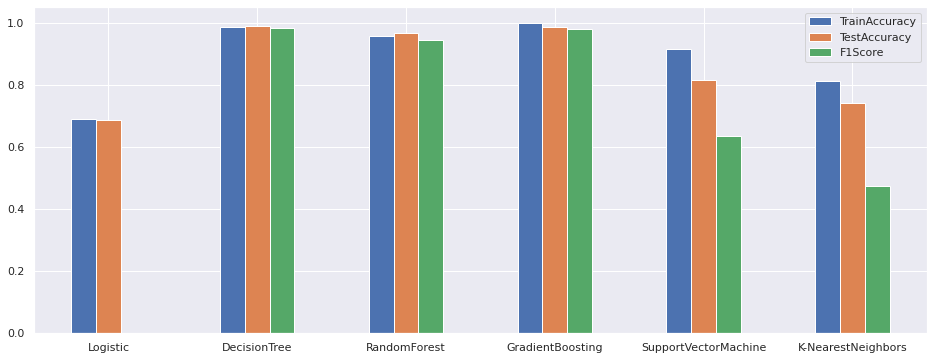

In [ ]:
ds_eval.plot.bar(rot = 0, figsize = (16, 6));

의사결정나무가 가장 높은 정확도와 F1-score을 보였다. 따라서 주요 영향 인자들은 Decision Tree의 결과를 토대로 판단할 것이다.

## 5, 핵심영향인자 선정 및 결과 해석

Decision Tree( 의사결정나무 )를 토대로 한 설명변수 중요도

In [ ]:
df_feature_importance = pd.DataFrame()
df_feature_importance["feature"] = df_train_x.columns
df_feature_importance["importance"] = tree_fin.feature_importances_
df_feature_importance.sort_values(by="importance",ascending=False, inplace = True)
df_feature_importance[:10].round(3)

,feature,importance
8,rolling_temp,0.567
86,hsb_적용,0.158
5,fur_soak_temp,0.154
0,pt_thick,0.095
9,descaling_count,0.014
2,pt_length,0.006
3,fur_heat_temp,0.004
6,fur_soak_time,0.002
79,spec_country_영국,0.001
7,fur_total_time,0.000


Decision Tree 모델의 결과로 나온 핵심영향인자는 다음과 같다.  
1. rolling_temp( 압연온도 )
2. hsb_미적용( Hot Scale Braker의 적용 여부 )
3. fur_soak_temp( 가열로 균열대 소재온대 )
4. Descaling_count( 압연 descaling 횟수 )
5. pt_length( 후판 지시길이 )
  
  